<a href="https://colab.research.google.com/github/grnvlt-9810/cnn-model-for-fyp/blob/main/3-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import subprocess
from random import choice
from skimage.util import random_noise
from skimage.transform import resize
from scipy.ndimage import rotate
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, ResNet50, VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# constant seed number
seed=34581
np.random.seed(34581)
tf.random.set_seed(34581)

In [ ]:
zip_path = '/content/drive/MyDrive/swdb.zip'
extr_path = 'swdb'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extr_path)

In [ ]:
# Set the path to the directory containing the folders
dir_path = '/content/swdb/swdb'

# Get a list of all folders in the directory
folders = [folder for folder in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, folder))]

Iterate through files in the folder to check for format discrepancies

In [ ]:
# Set the target size for the images
target_width = 250
target_height = 250

# Set the path to the directory containing the folders
dir_path = '/content/swdb/swdb'

# Set the path to the directory to save the resized files
save_dir = 'database/swdb_resize'

# Delete the existing contents of the save_directory if it already exists
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

# Iterate through each folder
for folder in os.listdir(dir_path):
    # Get the list of files in the folder
    folder_path = os.path.join(dir_path, folder)
    files = os.listdir(folder_path)

    # Create a folder to save the resized files
    save_folder = os.path.join(save_dir, folder)
    os.makedirs(save_folder, exist_ok=True)

    # Iterate through each file in the folder
    for file in files:
        # Check file
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            # Resize the image
            file_path = os.path.join(folder_path, file)
            img = mpimg.imread(file_path)
            resized_img = resize(img, (target_height, target_width))

            # Save the resized image in the save directory
            save_file = os.path.join(save_folder, file)
            plt.imsave(save_file, resized_img)

            print(f"Resized file saved: {save_file}")


Augmentating files to add iversity to the dataset

In [ ]:
# Set the path to the directory containing the folders
dir_path = '/content/database/swdb_resize'

# Get a list of all folders in the directory
folders = [folder for folder in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, folder))]

# Look through each folder
for folder in folders:
    # Get the list of files in the folder
    folder_path = os.path.join(dir_path, folder)
    files = os.listdir(folder_path)

    # Look through each file in the folder
    for file in files:
        # Check file extension
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            # Load the resized image
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)

            # Save the resized image
            resized_img_path = os.path.join(folder_path, 'resized_' + file)
            cv2.imwrite(resized_img_path, img)

            # Add salt and pepper noise
            noise_img = random_noise(img, mode='s&p', amount=0.2, seed=34581)
            noise_img = np.array(255 * noise_img, dtype=np.uint8)
            noise_folder_path = os.path.join(dir_path, folder + '_resize_noise')
            os.makedirs(noise_folder_path, exist_ok=True)
            noise_img_path = os.path.join(noise_folder_path, 'noise_' + file)
            cv2.imwrite(noise_img_path, noise_img)

            # Random translation and rotation
            translate_rotate_img = img.copy()
            translation_percent = 0.2
            translation_x = int(translation_percent * target_width)
            translation_y = int(translation_percent * target_height)
            random_translation = choice(['left', 'right', 'top', 'bottom'])
            if random_translation == 'left':
                translate_rotate_img = np.roll(translate_rotate_img, -translation_x, axis=1)
            elif random_translation == 'right':
                translate_rotate_img = np.roll(translate_rotate_img, translation_x, axis=1)
            elif random_translation == 'top':
                translate_rotate_img = np.roll(translate_rotate_img, -translation_y, axis=0)
            elif random_translation == 'bottom':
                translate_rotate_img = np.roll(translate_rotate_img, translation_y, axis=0)
            random_angle = choice([0, 90, 180, 270])
            translate_rotate_folder_path = os.path.join(dir_path, folder + '_resize_translate_rotate')
            os.makedirs(translate_rotate_folder_path, exist_ok=True)
            translate_rotate_img_path = os.path.join(translate_rotate_folder_path, 'translate_rotate_' + file)
            cv2.imwrite(translate_rotate_img_path, translate_rotate_img)

            # Random translation and flipping
            translate_flip_img = img.copy()
            random_translation = choice(['left', 'right', 'top', 'bottom'])
            if random_translation == 'left':
                translate_flip_img = np.roll(translate_flip_img, -translation_x, axis=1)
            elif random_translation == 'right':
                translate_flip_img = np.roll(translate_flip_img, translation_x, axis=1)
            elif random_translation == 'top':
                translate_flip_img = np.roll(translate_flip_img, -translation_y, axis=0)
            elif random_translation == 'bottom':
                translate_flip_img = np.roll(translate_flip_img, translation_y, axis=0)
            random_flip = choice(['horizontal', 'vertical'])
            if random_flip == 'horizontal':
                translate_flip_img = cv2.flip(translate_flip_img, 1)
            elif random_flip == 'vertical':
                translate_flip_img = cv2.flip(translate_flip_img, 0)
            translate_flip_folder_path = os.path.join(dir_path, folder + '_resize_translate_flip')
            os.makedirs(translate_flip_folder_path, exist_ok=True)
            translate_flip_img_path = os.path.join(translate_flip_folder_path, 'translate_flip_' + file)
            cv2.imwrite(translate_flip_img_path, translate_flip_img)

            print(f"Transformed copies created for file: {file}")


Transformed copies created for file: burns (42).jpg
Transformed copies created for file: burns (67).jpg
Transformed copies created for file: burns (35).jpg
Transformed copies created for file: burns (29).jpg
Transformed copies created for file: burns (45).jpg
Transformed copies created for file: burns (22).jpg
Transformed copies created for file: burns (17).jpg
Transformed copies created for file: burns (53).jpg
Transformed copies created for file: burns (55).jpg
Transformed copies created for file: burns (47).jpg
Transformed copies created for file: burns (77).jpg
Transformed copies created for file: burns (9).jpg
Transformed copies created for file: burns (60).jpg
Transformed copies created for file: burns (54).jpg
Transformed copies created for file: burns (46).jpg
Transformed copies created for file: burns (72).jpg
Transformed copies created for file: burns (20).jpg
Transformed copies created for file: burns (7).jpg
Transformed copies created for file: burns (31).jpg
Transformed co

Bunch of codes for rearranging codes into its folder

In [ ]:
#SUP BURNS
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/SUP BURNS_resize_noise'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/SUP BURNS'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

#BRUISE
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/BRUISE_resize_noise'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/BRUISE'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

#ABRASION
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/ABRASION_resize_noise'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/ABRASION'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

'/content/database/swdb_resize/ABRASION/ABRASION_resize_noise'

In [ ]:
#SUP BURNS
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/SUP BURNS_resize_translate_rotate'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/SUP BURNS'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

#BRUISE
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/BRUISE_resize_translate_rotate'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/BRUISE'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

#ABRASION
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/ABRASION_resize_translate_rotate'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/ABRASION'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

'/content/database/swdb_resize/ABRASION/ABRASION_resize_translate_rotate'

In [ ]:
#SUP BURNS
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/SUP BURNS_resize_translate_flip'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/SUP BURNS'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

#BRUISE
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/BRUISE_resize_translate_flip'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/BRUISE'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

#ABRASION
# Source folder (the folder you want to move)
source_folder = '/content/database/swdb_resize/ABRASION_resize_translate_flip'

# Destination subfolder (where you want to move the source folder)
destination_subfolder = '/content/database/swdb_resize/ABRASION'

# Use shutil.move to move the source folder to the destination
shutil.move(source_folder, destination_subfolder)

'/content/database/swdb_resize/ABRASION/ABRASION_resize_translate_flip'

In [ ]:
# Set the path to the parent subfolder
parent_folder = '/content/database/swdb_resize/SUP BURNS'

# Get the list of subfolders within the parent folder
subfolders = [f.path for f in os.scandir(parent_folder) if f.is_dir()]

# Iterate over the subfolders
for subfolder in subfolders:
    # Get the list of items within the subfolder
    items = os.listdir(subfolder)

    # Move the items to the parent folder
    for item in items:
        item_path = os.path.join(subfolder, item)
        shutil.move(item_path, parent_folder)

    # Delete the subfolder
    shutil.rmtree(subfolder)

In [ ]:
# Set the path to the parent subfolder
parent_folder = '/content/database/swdb_resize/BRUISE'

# Get the list of subfolders within the parent folder
subfolders = [f.path for f in os.scandir(parent_folder) if f.is_dir()]

# Iterate over the subfolders
for subfolder in subfolders:
    # Get the list of items within the subfolder
    items = os.listdir(subfolder)

    # Move the items to the parent folder
    for item in items:
        item_path = os.path.join(subfolder, item)
        shutil.move(item_path, parent_folder)

    # Delete the subfolder
    shutil.rmtree(subfolder)

In [ ]:
# Set the path to the parent subfolder
parent_folder = '/content/database/swdb_resize/ABRASION'

# Get the list of subfolders within the parent folder
subfolders = [f.path for f in os.scandir(parent_folder) if f.is_dir()]

# Iterate over the subfolders
for subfolder in subfolders:
    # Get the list of items within the subfolder
    items = os.listdir(subfolder)

    # Move the items to the parent folder
    for item in items:
        item_path = os.path.join(subfolder, item)
        shutil.move(item_path, parent_folder)

    # Delete the subfolder
    shutil.rmtree(subfolder)

In [ ]:
# Path to the dataset directory
dataset_dir = '/content/database/swdb_resize'

# Delete the .ipynb_checkpoints folder
ipynb_checkpoints_dir = os.path.join(dataset_dir, '.ipynb_checkpoints')
if os.path.exists(ipynb_checkpoints_dir):
    os.rmdir(ipynb_checkpoints_dir)
    print(".ipynb_checkpoints folder deleted.")
else:

    print(".ipynb_checkpoints folder does not exist.")

.ipynb_checkpoints folder does not exist.


Codes to split all classes of augmented images/files to 90:10 training-validation:testing, then moving them to their respective folders

In [ ]:
# Step 1: Label all images in subfolders
parent_folder = '/content/database/swdb_resize'
class_labels = {'ABRASION': 0, 'BRUISE': 1, 'SUP BURNS': 2}

# Step 2: Create 'train' and 'test' folders
train_folder = os.path.join(parent_folder, 'train')
test_folder = os.path.join(parent_folder, 'test')

if not os.path.exists(train_folder):
    os.makedirs(train_folder)

if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Step 3-7: Split and move images for each class
for class_name, label in class_labels.items():
    class_folder = os.path.join(parent_folder, class_name)

    # Step 3: Shuffle and split images
    all_images = os.listdir(class_folder)
    random.shuffle(all_images)
    split_index = int(0.9 * len(all_images))

    # Step 4-6: Move images to 'train' and 'test' folders
    train_images = all_images[:split_index]
    test_images = all_images[split_index:]

    train_class_folder = os.path.join(train_folder, class_name)
    test_class_folder = os.path.join(test_folder, class_name)

    if not os.path.exists(train_class_folder):
        os.makedirs(train_class_folder)

    if not os.path.exists(test_class_folder):
        os.makedirs(test_class_folder)

    for img in train_images:
        shutil.move(os.path.join(class_folder, img), os.path.join(train_class_folder, img))

    for img in test_images:
        shutil.move(os.path.join(class_folder, img), os.path.join(test_class_folder, img))

def delete_empty_folders(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            if not os.listdir(folder_path):
                os.rmdir(folder_path)

directory_to_check = '/content/database/swdb_resize'
delete_empty_folders(directory_to_check)

Print total number of files in each directory

In [ ]:
def count_images_in_folders(directory):
    for root, dirs, files in os.walk(directory):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            total_images = len([file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))])
            print(f"Folder: {folder}, Total Images: {total_images}")

directory_to_check = '/content/database/swdb_resize'
count_images_in_folders(directory_to_check)


Folder: test, Total Images: 0
Folder: train, Total Images: 0
Folder: SUP BURNS, Total Images: 43
Folder: ABRASION, Total Images: 43
Folder: BRUISE, Total Images: 43
Folder: SUP BURNS, Total Images: 382
Folder: ABRASION, Total Images: 382
Folder: BRUISE, Total Images: 382


Input feeding to the model with normalization augmentation for all images/files

In [ ]:
# Path to the extracted dataset directory
dataset_dir = '/content/database/swdb_resize/train'

# Define classes
classes = ['ABRASION', 'BRUISE', 'SUP BURNS']

img_size = (299, 299)
batch_size=32

# Re-configure the data generator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # 80% for  training 20% for validation

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=seed,
    class_mode='categorical',
    subset='training')  # 80% training

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=seed,
    class_mode='categorical',
    subset='validation')  # 20% validation set

Found 918 images belonging to 3 classes.
Found 228 images belonging to 3 classes.


Base model, since all model used the same setup just comment and uncomment any line of base model

In [ ]:
# Load InceptionV3 pre-trained model
model = Sequential()
model.add(InceptionV3(include_top=False, pooling='avg', weights=None))
# model.add(ResNet50(include_top=False, pooling='avg', weights=None))
# model.add(VGG16(include_top=False, pooling='avg', weights=None))
model.add(Dense(1024, activation='relu'))
num_classes = len(classes)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, steps_per_epoch=train_generator.samples//batch_size, epochs=100, validation_data=val_generator, validation_steps=val_generator.samples//batch_size)
model.save_weights('best_weights.h5')


Epoch 1/100
28/28 [==============================] - 91s 2s/step - loss: 1.6396 - accuracy: 0.3702 - val_loss: 1.5559 - val_accuracy: 0.3393
Epoch 2/100
28/28 [==============================] - 29s 1s/step - loss: 1.0613 - accuracy: 0.4673 - val_loss: 1.1106 - val_accuracy: 0.3393
Epoch 3/100
28/28 [==============================] - 35s 1s/step - loss: 0.9923 - accuracy: 0.5079 - val_loss: 1.2841 - val_accuracy: 0.3259
Epoch 4/100
28/28 [==============================] - 29s 1s/step - loss: 0.9295 - accuracy: 0.5790 - val_loss: 1.2613 - val_accuracy: 0.3348
Epoch 5/100
28/28 [==============================] - 31s 1s/step - loss: 0.9110 - accuracy: 0.6005 - val_loss: 1.2639 - val_accuracy: 0.3348
Epoch 6/100
28/28 [==============================] - 33s 1s/step - loss: 0.8341 - accuracy: 0.6479 - val_loss: 1.4644 - val_accuracy: 0.3348
Epoch 7/100
28/28 [==============================] - 30s 1s/step - loss: 0.7184 - accuracy: 0.7032 - val_loss: 1.2360 - val_accuracy: 0.3705
Epoch 8/100
2

Plotting for training & validation (for both accuracy and loss)

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.show()

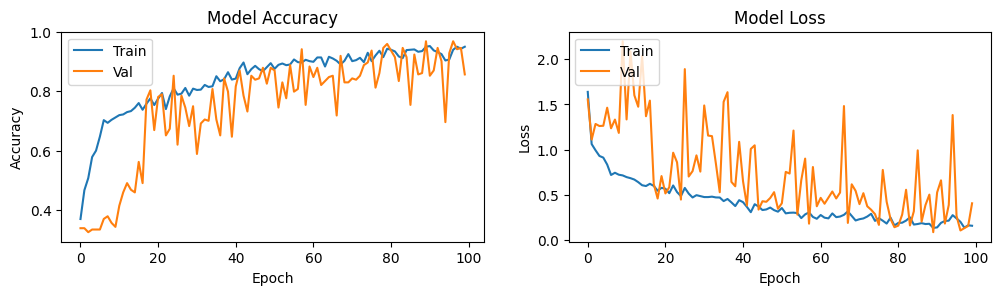

In [ ]:
plot_training_history(history)

Similar normalization augmentation for testing and predicting, though the use of model.evalute results is not recorded into results finding

In [ ]:
test_dir='/content/database/swdb_resize/test'

# Create data generators with data augmentation
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=210,
    class_mode='categorical')

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples//batch_size+1)
print('Test accuracy:', test_acc)
print('Test Loss:', test_loss)

Found 129 images belonging to 3 classes.
5/5 [==============================] - 4s 621ms/step - loss: 0.5042 - accuracy: 0.7984
Test accuracy: 0.7984496355056763
Test Loss: 0.5041823387145996


Generating prediction and its confusion matrix

5/5 [==============================] - 3s 558ms/step
              precision    recall  f1-score   support

    ABRASION       0.46      0.44      0.45        43
      BRUISE       0.50      0.30      0.38        43
   SUP BURNS       0.39      0.56      0.46        43

    accuracy                           0.43       129
   macro avg       0.45      0.43      0.43       129
weighted avg       0.45      0.43      0.43       129



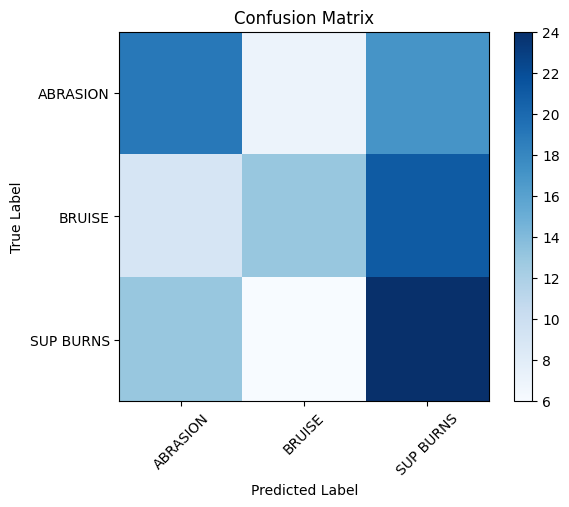

In [ ]:
# Generate predictions
X_test=test_generator
model.load_weights('best_weights.h5')
y_pred = model.predict(X_test, steps=test_generator.samples//batch_size+1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate classification report
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(np.array(y_true), y_pred_classes)

# Show confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Display of the raw confusion matrix and calculation of each class accuracy, for the sake check-and-balance to the printed confusion matrix.

Raw Confusion Matrix:
[[19  7 17]
 [ 9 13 21]
 [13  6 24]]

Normalized Confusion Matrix:
[[0.44186047 0.1627907  0.39534884]
 [0.20930233 0.30232558 0.48837209]
 [0.30232558 0.13953488 0.55813953]]


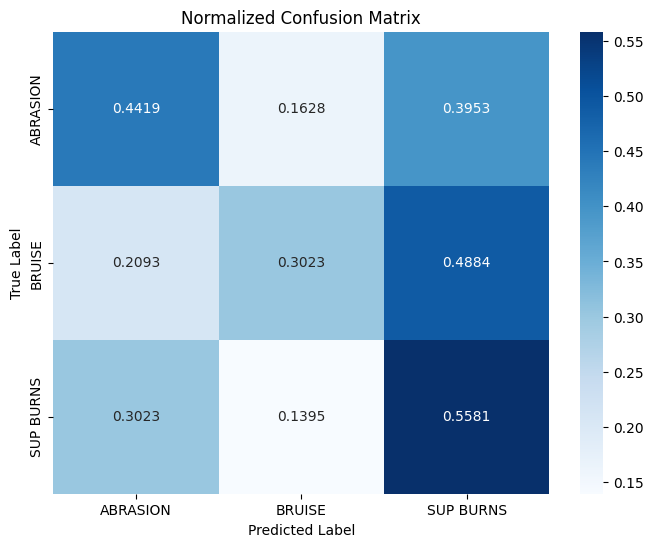


Class-wise Accuracy:
ABRASION: 0.4419
BRUISE: 0.3023
SUP BURNS: 0.5581


In [ ]:
import seaborn as sns
print("Raw Confusion Matrix:")
print(cm)

# Normalize confusion matrix
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix:")
print(normalized_cm)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt='.4f', xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and print each class accuracy
class_accuracy = np.diag(normalized_cm)
class_accuracy_dict = dict(zip(class_names, class_accuracy))

print("\nClass-wise Accuracy:")
for class_name, acc in class_accuracy_dict.items():
    print(f"{class_name}: {acc:.4f}")

Printing each classes metric from confusion matrix

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average=None)

for i, class_name in enumerate(class_names):
    print(f"\nMetrics for class '{class_name}':")
    print("  Precision:", f"{precision[i]:.4f}")
    print("  Recall:", f"{recall[i]:.4f}")
    print("  F1-Score:", f"{f1_score[i]:.4f}")


Metrics for class 'ABRASION':
  Precision: 0.4634
  Recall: 0.4419
  F1-Score: 0.4524

Metrics for class 'BRUISE':
  Precision: 0.5000
  Recall: 0.3023
  F1-Score: 0.3768

Metrics for class 'SUP BURNS':
  Precision: 0.3871
  Recall: 0.5581
  F1-Score: 0.4571


Calculating sensitivity and specificity with the raw data of confusion matrix

In [ ]:
# Calculate Spec and Sens
sensitivity = np.diag(cm) / np.sum(cm, axis=1)
specificity = []
for i in range(cm.shape[0]):
    tn = np.delete(cm, i, axis=0)[:, np.delete(np.arange(cm.shape[0]), i)]
    fp = np.delete(cm, i, axis=0)[:, i]
    specificity.append(np.sum(tn) / (np.sum(tn) + np.sum(fp)))
specificity = np.array(specificity)

# Calculate accuracy/rand index (acc)
acc = np.sum(np.diag(cm)) / np.sum(cm)

print('Confusion Matrix: ', cm)
print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)
print('Accuracy: ', acc)

Confusion Matrix:  [[19  7 17]
 [ 9 13 21]
 [13  6 24]]
Sensitivity:  [0.44186047 0.30232558 0.55813953]
Specificity:  [0.74418605 0.84883721 0.55813953]
Accuracy:  0.43410852713178294
